Kamil Młynarczyk, 240757, WEEiA, Informatyka, grupa 5I EAiBD1

<p style="text-align:center; font-size:30px;">Projekt Analiza Danych 2023/2024</p>

# Wstęp


<p style="font-size:16px;">Cel projektu:</p>
Celem projektu była analiza danych pod kątem wyznaczenia cech, klasyfikacji przy użyciu różnych algorytmów oraz zestawienia wykresów przy pomocy języka Python, jak również wysnucia własnych wniosków.

<p style="font-size:16px;">Zestaw Danych:</p>
Jako zestaw danych wybrałem „Pima Indians Diabetes Database” ze strony kaggle.com. Celem zbioru, na podstawie pomiarów diagnostycznych, jest wyznaczenie czy pacjent ma cykrzycę czy nie. Grupą badanych ludzi są kobiety w wieku nie mniejszym niż 21 lat o pochodzeniu natywnych amerykanów z plemienia „Pima”. 
Link do zestawu: kaggle.com/datasets/uciml/pima-indians-diabetes-database/data
Zbiór danych składa się z kilku medycznych zmiennych prognostycznych i jednej zmiennej docelowej:
a) Do zmiennych prognostycznych zaliczamy (wszystkie zmienne są numeryczne):
* Insulin: 2-godzinna insulina w surowicy (mu U/ml)
- Glukose: stężenie glukozy w osoczu po 2 godzinach w doustnym teście tolerancji glukozy (mm Hg)
- Pregnancies:  liczba zajść w ciążę
- BloodPressure: rozkurczowe ciśnienie krwi (mm/Hg)
- SkinThickness: grubość fałdu skórnego mięśnia trójgłowego uda (mm)
- BMI: wskaźnik masy ciała (waga w kg/(wzrost w m)^2)
- DiabetesPedigreeFunction: Funkcja rodowodu cukrzycy
- Age: Wiek (lata)
b) Do zmiennej docelowej zaliczamy: 
- Output: zmienna klasy (0 – nie chory lub 1 - chory)

<p style="font-size:16px;">Podstawowe dane zbioru:</p>
- Średnia wieku: 30 lat, minimalny: 21, maksymalny: 81,
- Średni poziom glukozy: 122, minimalny: 55, maksymalny: 198,
- Średni poziom insuliny: 156, minimalny: 14, maksymalny: 846,
- Średnie BMI: 33, minimalne: 18.2, maksymalne: 67.1,


In [70]:
#używane biblioteki
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# PREPROCESS
from sklearn.impute import KNNImputer
from scipy.stats import zscore
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

#pomiar klasyfikacji
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#modele klasyfikacji
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [71]:
# Wczytaj dane z pliku CSV
df = pd.read_csv('diabetes_1.csv')

# Podstawowe informacje
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [72]:
df.shape

(768, 9)

Na samym początku przyjżymy się danym bez wcześniejszego PREPROCESSINGU.

Licznik wartości zero przed PREPROCESSINGIEM:
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


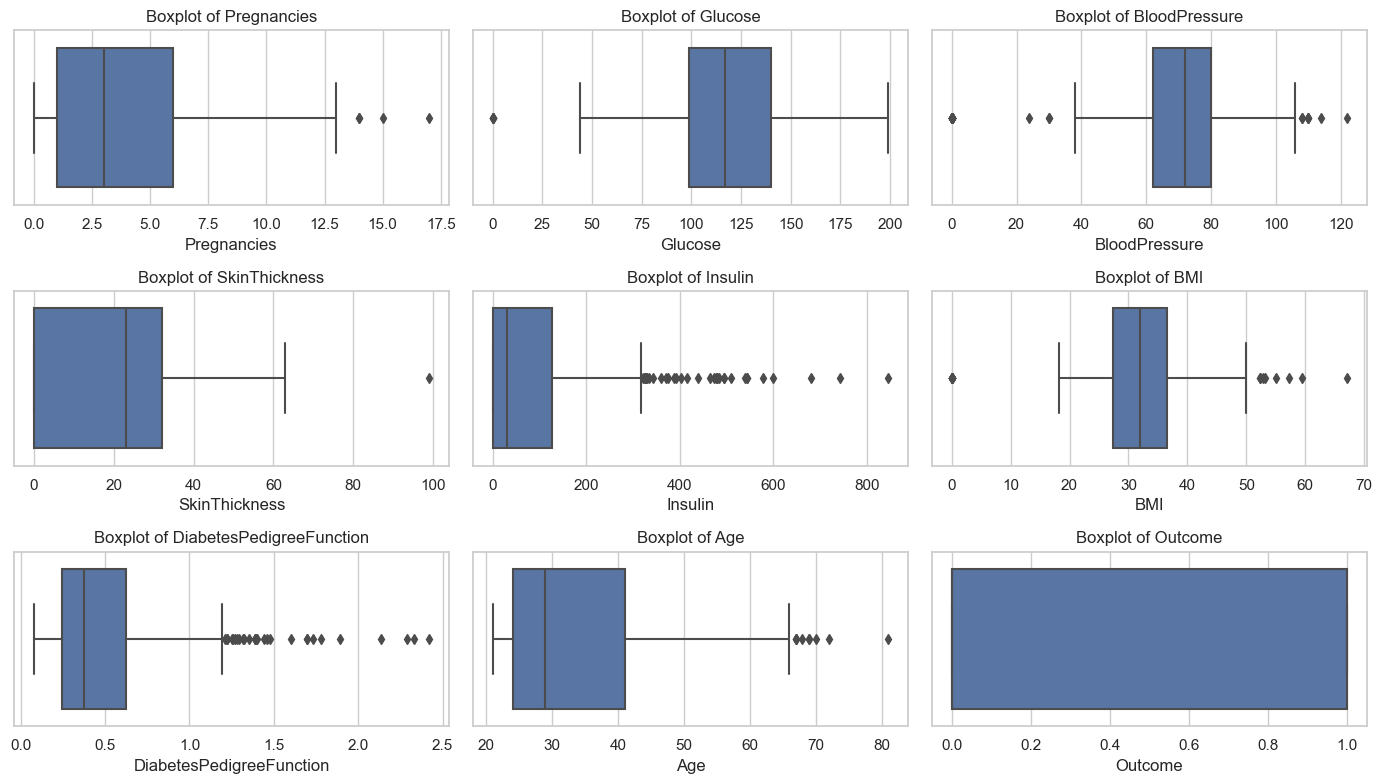

In [73]:
columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

print("Licznik wartości zero przed PREPROCESSINGIEM:")
print(df[columns_with_zeros].eq(0).sum())

numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(14, 8))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

# Preprocessing

Zawuażyć można, iż w bardzo dużej ilości miejsc występuje wartość zero, co oznacza, że danej kobiecie nie zlecano wszystkich badań a na przykład jedynie na stężenie glukozy w osoczu (tych danych jest najwięcej).
Aby wyeliminować tę sytuację, na wiersze w których wartości są równe zero, zastosowałem metodę KNN imputation.

In [74]:
df[columns_with_zeros] = df[columns_with_zeros].replace(0, np.nan)

imputer = KNNImputer(n_neighbors=6)

df[columns_with_zeros] = imputer.fit_transform(df[columns_with_zeros])

print("Licznik wartości zero po PREPROCESSINGU:")
print(df[columns_with_zeros].eq(0).sum())

Licznik wartości zero po PREPROCESSINGU:
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64


Na wykresach box-plot widać również, że instnieją wartości bardzo odstające od reszty (outliers), aby je usunąć zastosowałem metodę Z-score.

In [75]:
z_scores = zscore(df[numerical_columns])

# próg odchylenia standardowego = 3
threshold = 3

# Usuwanie wierszy zawierających outlierów
df = df[(abs(z_scores) < threshold).all(axis=1)]

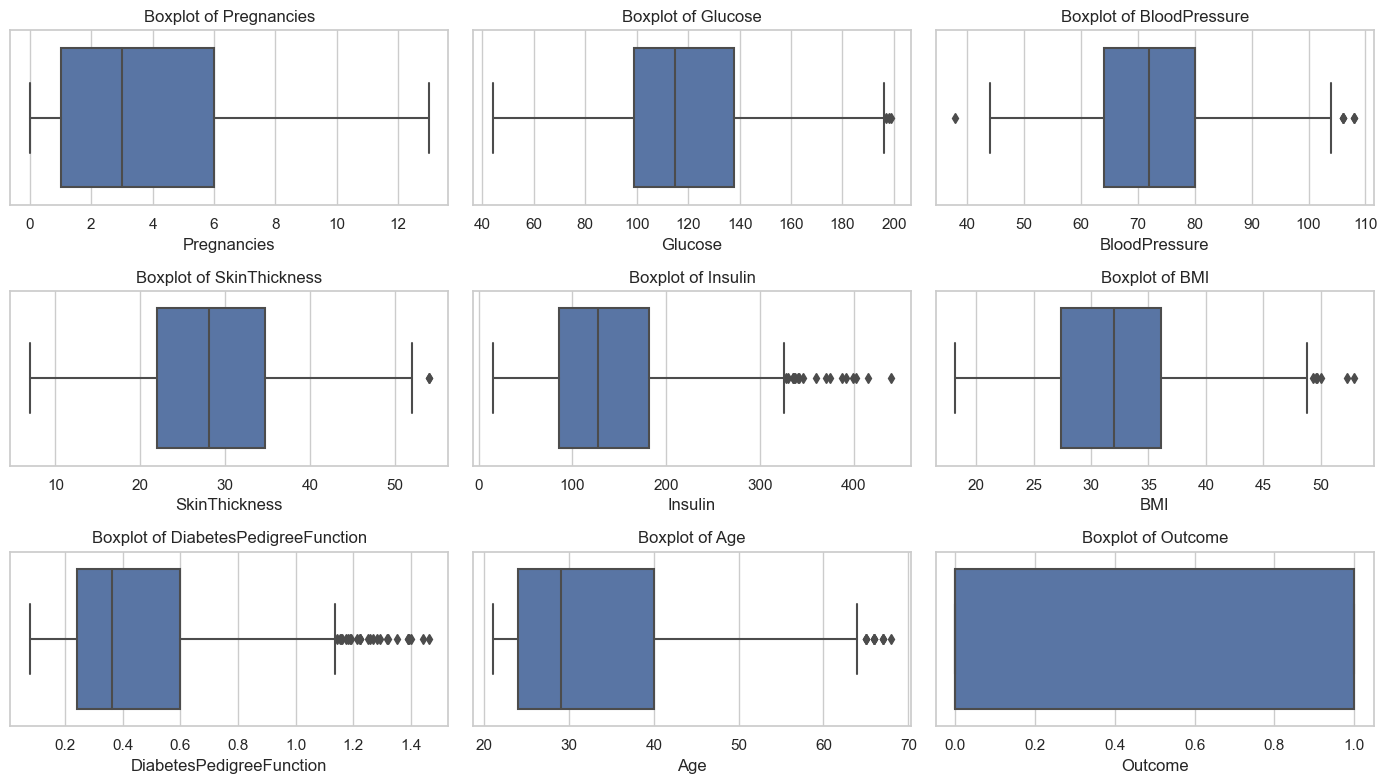

In [76]:
plt.figure(figsize=(14, 8))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

W ten sposób pozbyłem się wartości równych 0, zaburzających przebieg dalszego działanie jak i wyeliminowałem próbki bardzo odstające od reszty.

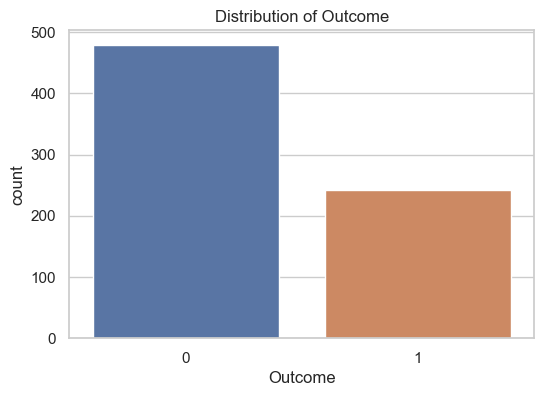

In [77]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Outcome', data=df)
plt.title('Distribution of Outcome')
plt.show()

Na powyższym wykresie widać nieproporcjonalną ilość osób chorych i zdrowych. Postanowiłem, użyć metody SMOTE do oversamplingu aby wyrównać dystrybucję.

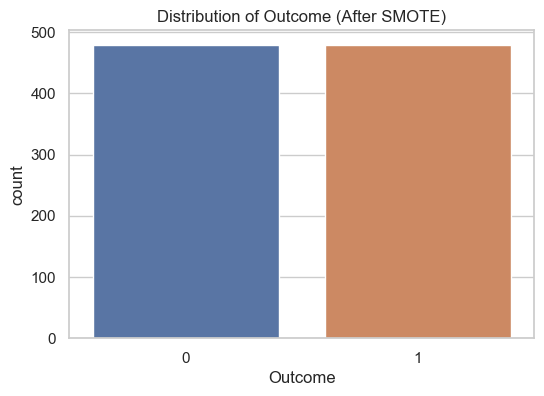

In [78]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='Outcome')], axis=1)


plt.figure(figsize=(6, 4))
sns.countplot(x='Outcome', data=df)
plt.title('Distribution of Outcome (After SMOTE)')
plt.show()



# 

Wizualizacja korelacji za pomocą macierzy korelacji.

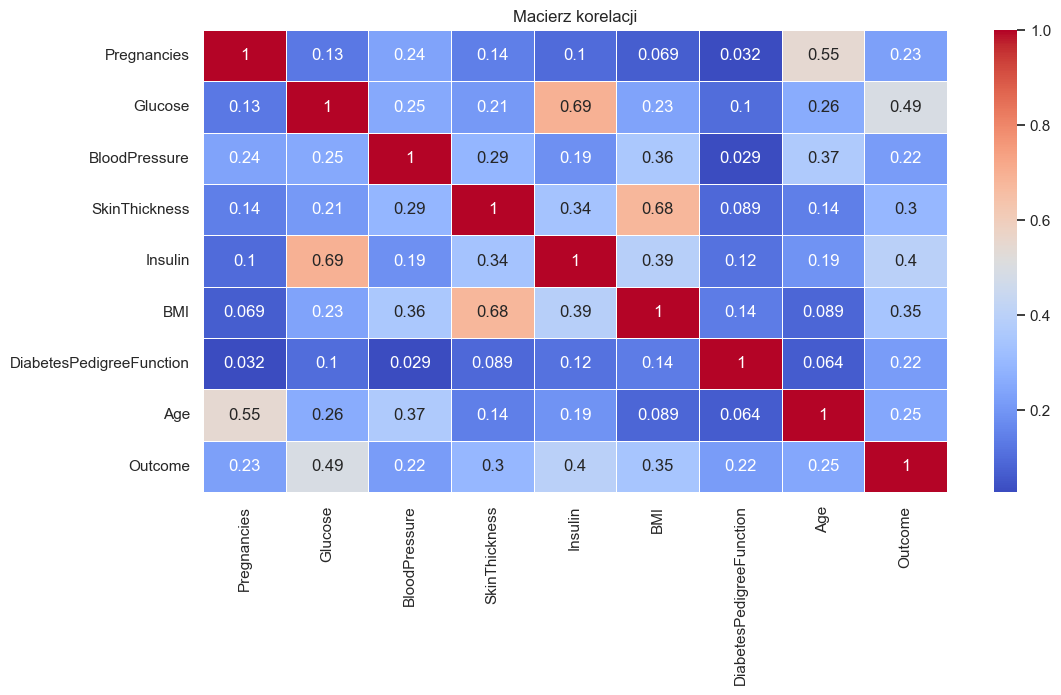

In [79]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Macierz korelacji')
plt.show()

Zauważyć korelację możemy pomiędzy: wiekiem a liczbą ciąż, poziomem glukozy w osoczu a poziomem insuliny, grubością skury na tricepsie a wskaźnikiem BMI. Najbardziej istotnymi relacjami jednak w mojej analizie są relacje związane z "outcome" czyli z tym czy ktoś choruje na cukrzycę czy nie, i zauważyć mogę, że największymi takimi zależnościami są poziom glukozy w osoczu i poziom insuliny.

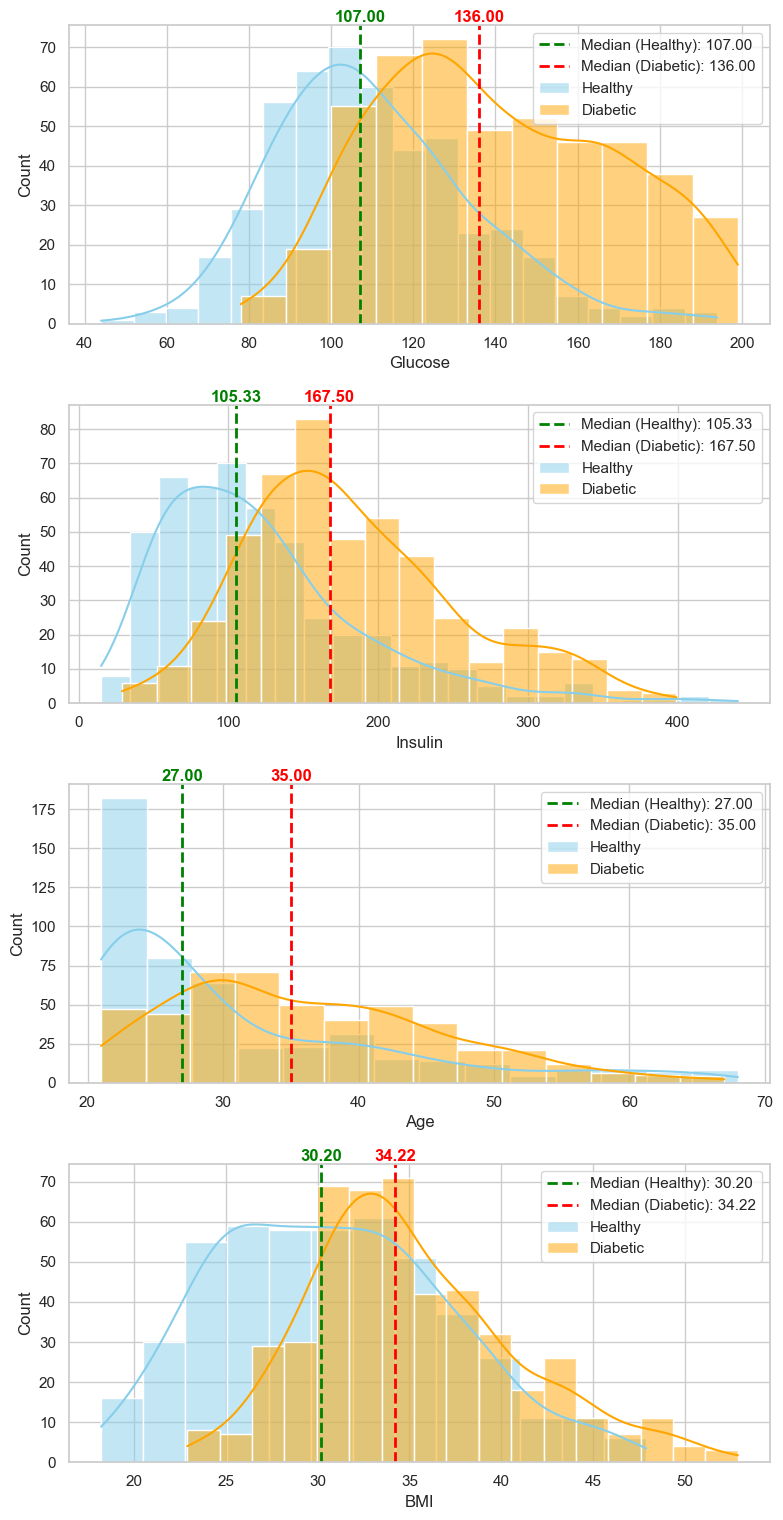

In [80]:
# Wybierz dane dla osób zdrowych (Outcome=0)
healthy_data = df[df['Outcome'] == 0]

# Wybierz dane dla osób chorych (Outcome=1)
diabetic_data = df[df['Outcome'] == 1]

sns.set(style="whitegrid")
fig, axes = plt.subplots(4, 1, figsize=(8, 16))

features = ['Glucose', 'Insulin', 'Age', 'BMI']

for i, feature in enumerate(features):
    # Wykres dla danej cechy
    sns.histplot(healthy_data[feature], kde=True, color='skyblue', label='Healthy', ax=axes[i])
    sns.histplot(diabetic_data[feature], kde=True, color='orange', label='Diabetic', ax=axes[i])

    median_healthy = healthy_data[feature].median()
    median_diabetic = diabetic_data[feature].median()
    axes[i].axvline(median_healthy, color='green', linestyle='dashed', linewidth=2, label=f'Median (Healthy): {median_healthy:.2f}')
    axes[i].axvline(median_diabetic, color='red', linestyle='dashed', linewidth=2, label=f'Median (Diabetic): {median_diabetic:.2f}')

    axes[i].legend()

    axes[i].text(median_healthy, axes[i].get_ylim()[1], f'{median_healthy:.2f}', ha='center', va='bottom', color='green', fontweight='bold')
    axes[i].text(median_diabetic, axes[i].get_ylim()[1], f'{median_diabetic:.2f}', ha='center', va='bottom', color='red', fontweight='bold')
    
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Wyświetl wykresy
plt.show()

Z powyższych wykresów możemy zauważyć różnicę pomiędzy osobami zdrowymi a chorymi na podstawie ich poziomu glukozy, insuliny, wieku i wskaźnika BMI. Poziom glukozy przeciętnej zdrowej kobiety wynosi 107 mm/Hg a chorującej na cukrzycę juz o 30 jednostek więcej, 136 mm/Hg. To samo można powiedzieć o insulinie, wieku i wskaźniku BMI, gdzie te wartości to odpowiednio:
- poziom insuliny: Zdrowa 105 mu U/ml, Chora 167 mu U/ml
- wiek: Zdrowa 27, Chora 35, (może być to jednak spowodowane znacznie większą ilością kobiet w młodym wieku w tej badzie danych)
- wskaźnik BMI: Zdrowa 30, Chora 34

# Klasyfikacja

Do zadania klasyfikacji, czy osoba jest chora na cukrzycę czy nie, mając przygotowane dane, porównałem modele:
- Drzewo decyzyjne
- Regresja logiczna
- Sieć neuronową
- metodę Naive Bayes
- SVC
- klasyfikator Losowy las
- kNN
- wzmocnienia gradientowego

We wszystkich próbowałem ustawić jak najlepsze parametry i w rezultacie wyniki dokładności klasyfikacji wyszły na mniej więcej równym poziomie.


In [81]:
# Podziel dane na cechy (X) i target (y)
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Podziel dane na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=11)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Inicjalizuj modele
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=5, min_samples_split=2),
    'Neural Network': MLPClassifier(random_state=42, hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=1000),
    'Logistic Regression': LogisticRegression(random_state=42, C=1.0, solver='liblinear'),
    'Naive Bayes': GaussianNB(),
    'SVC': SVC(random_state=42, C=1.0, kernel='rbf', gamma='scale'),
    'Random Forest': RandomForestClassifier(random_state=42),
    'k-NN': KNeighborsClassifier(n_neighbors=9, weights="distance", metric="manhattan"),
    'Gradient Boosting': GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=3, random_state=42)
}

# Inicjalizuj listy do przechowywania wyników
model_names = []
accuracies = []
conf_matrices = []

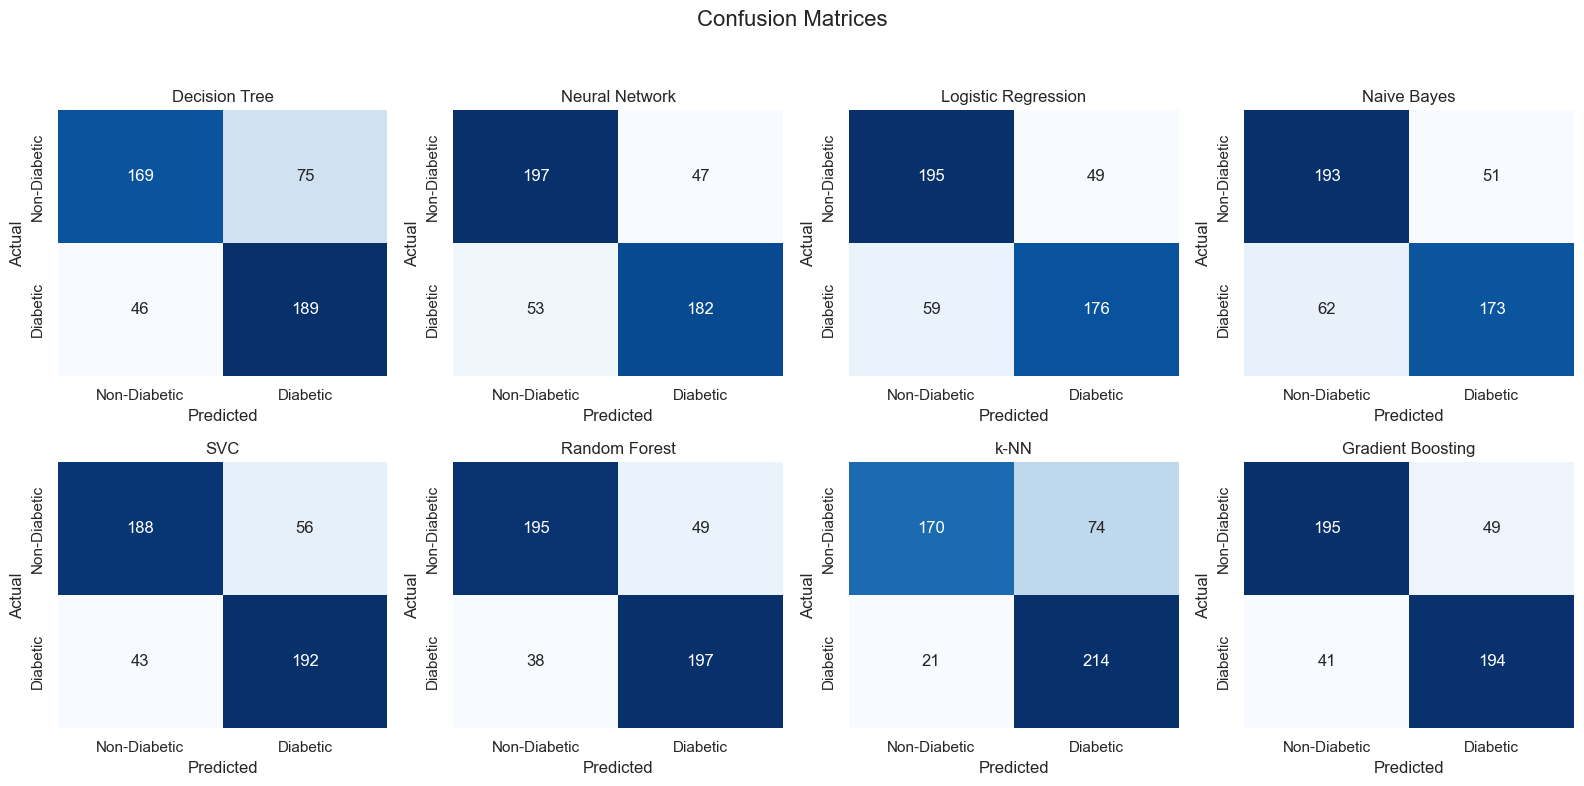

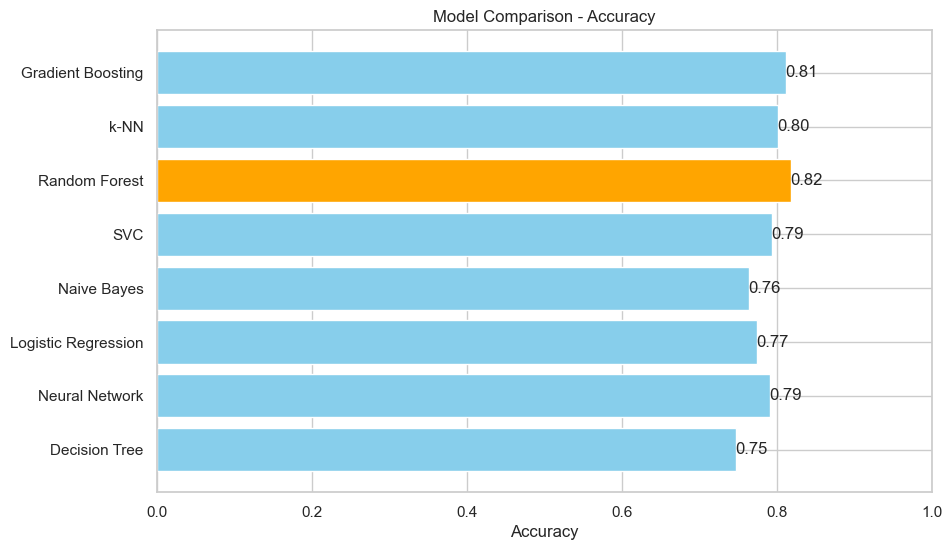

In [82]:
# Trenuj modele i zbierz wyniki
for model_name, model in models.items():
    # Dopasuj model do danych treningowych
    model.fit(X_train, y_train)

    # Wykonaj predykcje na danych testowych
    y_pred = model.predict(X_test)

    # Ocen jakość modelu
    accuracy = accuracy_score(y_test, y_pred)

    # Dodaj wyniki do list
    model_names.append(model_name)
    accuracies.append(accuracy)

    # Utwórz confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrices.append(conf_matrix)

# Wyświetl confusion matrix dla każdego modelu w subplots
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Confusion Matrices', fontsize=16)

for i, (model_name, conf_matrix) in enumerate(zip(model_names, conf_matrices)):
    ax = axes[i // 4, i % 4]
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non-Diabetic', 'Diabetic'],
                yticklabels=['Non-Diabetic', 'Diabetic'], ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{model_name}')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

best_model_index = accuracies.index(max(accuracies))

colors = ['skyblue' if i != best_model_index else 'orange' for i in range(len(models))]

plt.figure(figsize=(10, 6))
bars = plt.barh(model_names, accuracies, color=colors)
plt.xlabel('Accuracy')
plt.title('Model Comparison - Accuracy')

for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height() / 2, f'{accuracy:.2f}', ha='center', va='center')

plt.xlim(0, 1.0)
plt.show()

# Wnioski

Wszystkie modele wykazują mniej więcej podobne wyniki, na szczycie stawki znalazł się klasyfikator "Las losowy", z dokładnością powyżej 80%. 

Na podstawie przedstawionych informacji można wyciągnąć kilka istotnych wniosków dotyczących zależności pomiędzy różnymi czynnikami a występowaniem cukrzycy:
1. Poziom glukozy w osoczu: Wykresy wskazują na istotną różnicę między zdrowymi a chorymi osobami, gdzie poziom glukozy u pacjentów z cukrzycą jest znacznie wyższy (136 mm/Hg w porównaniu do 107 mm/Hg u osób zdrowych). To sugeruje, że wysoki poziom glukozy może być istotnym czynnikiem ryzyka dla wystąpienia cukrzycy.

2. Poziom insuliny: Podobnie jak w przypadku glukozy, istnieje znaczna różnica między zdrowymi a chorymi osobami, gdzie poziom insuliny jest istotnie wyższy u pacjentów z cukrzycą (167 mu U/ml w porównaniu do 105 mu U/ml u osób zdrowych). Może to wskazywać na związek między insuliną a cukrzycą, co jest zgodne z ogólnie znanym faktem, że cukrzyca typu 2 często wiąże się z insulinoopornością.

3. Wiek: Chorzy na cukrzycę wykazują wyższy średni wiek w porównaniu do osób zdrowych (35 lat w porównaniu do 27 lat u osób zdrowych). Niemniej jednak, autor zauważa, że może to być również związane z większą ilością młodych kobiet w analizie. W związku z tym, choć wiek może mieć pewien wpływ, należy być ostrożnym w wyciąganiu jednoznacznych wniosków na ten temat.

4. Wskaźnik BMI: Chorzy na cukrzycę wykazują wyższy wskaźnik BMI w porównaniu do osób zdrowych (34 w porównaniu do 30). To potwierdza, że otyłość może być istotnym czynnikiem ryzyka dla wystąpienia cukrzycy.

Aby uniknąć zachorowania na cukrzycę musimy pamiętać o zdrowej, zbalansowanej diecie ograniczając przy tym spożycie cukrów i tłuszczy nasyconych. Kobietom starszym zaleca się regularne badania profilaktyczne. Nie można również zapomnieć o ruchu fizycznym.